In [1]:
%matplotlib inline

In [2]:
# Install necessary modules.
# 必要なモジュールのインストール
!pip install rawpy
!pip install imageio

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# Import modules for raw image read.
# RAW読み込み用のモジュールのインポート
import io, requests, rawpy

In [4]:
# To download a file from github
# githubからファイルをダウンロード
response = requests.get("https://github.com/moizumi99/raw_process/raw/master/sample.ARW")
raw = rawpy.imread(io.BytesIO(response.content))

In [5]:
# if you want to use a local file, uncomment the below line
# ローカルのファイルを使う場合は以下の行をアンコメント
# raw = rawpy.imread('sample.ARW')

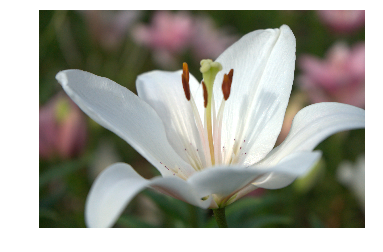

In [6]:
# Check the RAW file using rawpy.
# RAW画像をRAWPYの機能で確認。
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
img_preview = raw.postprocess(use_camera_wb=True)
imshow(img_preview)
plt.axis('off')
plt.show()

In [7]:
# Check the image size of the raw data
# RAW画像の画像サイズ確認。
print(raw.sizes)

ImageSizes(raw_height=4024, raw_width=6048, height=4024, width=6024, top_margin=0, left_margin=0, iheight=4024, iwidth=6024, pixel_aspect=1.0, flip=0)


In [8]:
# Convert to numpy so you can manipulate the pixels.
# 画像をnumpy形式に変更。これで操作が容易になる。
import numpy as np
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_image = raw.raw_image.copy()
raw_array = np.array(raw_image).reshape((h, w)).astype('float')

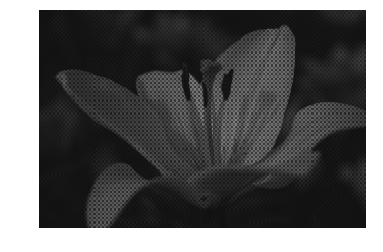

In [9]:
# Let's see the Bayer pattern image as is.
# Bayer画像をそのままグレイスケール画像として見てみる。
outimg = raw_array.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

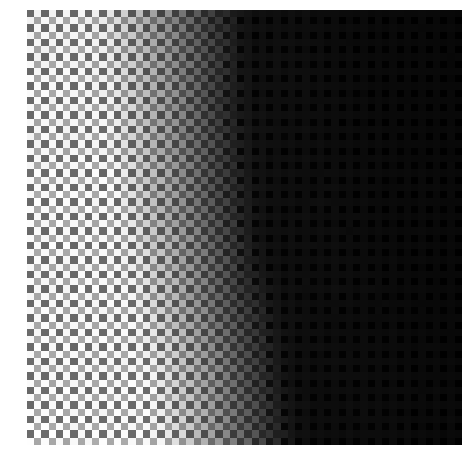

In [10]:
# Let's maginify the image to see the details.
# RAW画像の拡大。
plt.figure(figsize=(8, 8))
imshow(outimg[1310:1370, 2620:2680], cmap='gray')
plt.axis('off')
plt.show()

In [11]:
# Save the raw image as a gray scale image.
# RAW画像を画像ファイルとしてセーブしておく。
import imageio
raw_array_out = raw_array.copy()
raw_array_out = raw_array_out / raw_array_out.max() * 255
imageio.imwrite("raw_out.png", raw_array_out.astype('uint8'))

In [12]:
# Black level correction values.
# ブラックレベルの確認。
blc = raw.black_level_per_channel
print(blc)

[512, 512, 512, 512]


In [13]:
# Check the Bayer pattern. 0 = Red, 1 = Green, 2 = Blue, 3 = Green.
# ベイヤーパターンの確認。
bayer_pattern = raw.raw_pattern
print(bayer_pattern)

[[0 1]
 [1 2]]


In [14]:
# Do black level correction.
# ブラックレベル補正。
print("Minimum and Maximum before black level correction: ", raw_array.min(), raw_array.max())
blc_raw = raw_array.copy()
for y in range(0, h, 2):
    for x in range(0, w, 2):
        blc_raw[y + 0, x + 0] -= blc[bayer_pattern[0, 0]]
        blc_raw[y + 0, x + 1] -= blc[bayer_pattern[0, 1]]
        blc_raw[y + 1, x + 0] -= blc[bayer_pattern[1, 0]]
        blc_raw[y + 1, x + 1] -= blc[bayer_pattern[1, 1]]
print("Minimum and Maximum after black level correction: ", blc_raw.min(), blc_raw.max())

Minimum and Maximum before black level correction:  0.0 8180.0
Minimum and Maximum after black level correction:  -512.0 7668.0


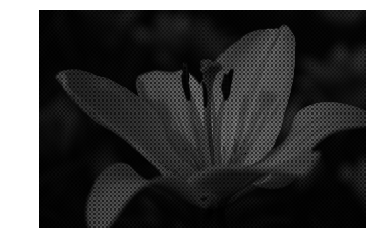

In [15]:
# Show the image after black level correction.
# ブラックレベル補正後の画像の確認。少し暗くなっている。
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
# Simplified demosaicing.
# 簡易デモザイク処理。
dms_img = np.zeros((h//2, w//2, 3))
for y in range(0, h, 2):
    for x in range(0, w, 2):
        colors = [0, 0, 0, 0]
        colors[bayer_pattern[0, 0]] += blc_raw[y + 0, x + 0]
        colors[bayer_pattern[0, 1]] += blc_raw[y + 0, x + 1]
        colors[bayer_pattern[1, 0]] += blc_raw[y + 1, x + 0]
        colors[bayer_pattern[1, 1]] += blc_raw[y + 1, x + 1]
        dms_img[y // 2, x // 2, 0] = colors[0]
        dms_img[y // 2, x // 2, 1] = (colors[1] + colors[3])/ 2
        dms_img[y // 2, x // 2, 2] = colors[2]

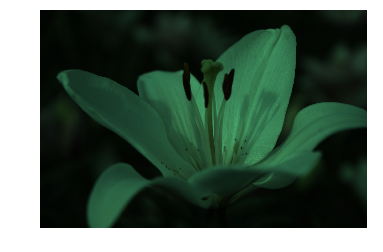

In [17]:
# Show the image after demosaic.
# デモザイク後の画像表示。
outimg = dms_img.copy()
outimg = outimg.reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()
# Don't worry about the color just yet.
# 色がおかしいのはこれから直していく。

In [18]:
# White balance gains from the camera.
# ホワイトバランスの確認。
wb = np.array(raw.camera_whitebalance)
print(wb)

[2288. 1024. 1544. 1024.]


In [19]:
# Apply white balance correction.
# ホワイトバランス補正。
img_wb = dms_img.copy().flatten().reshape((-1, 3))
for index, pixel in enumerate(img_wb):
    pixel = pixel * wb[:3] /max(wb)
    img_wb[index] = pixel

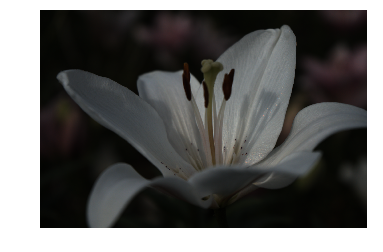

In [20]:
# Show the image after white balance correction.
# ホワイトバランス補正後の画像。
outimg = img_wb.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [21]:
# The color_matrix from raw_py doesn't seem to be right.
# raw_pyを使って得たカラーマトリクス値は正しくない。
print(raw.color_matrix)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [22]:
# Use the matrix from the exif information of the ARW file acquired by exiftool.
# 元のARWファイルからexiftoolを使って得たマトリクスを使用。
color_matrix = np.array([[1141, -205, 88], [-52, 1229, -154], [70, -225, 1179]]) / 1024

In [ ]:
# Apply Color matrix to the image.
# カラーマトリクス補正。
img_ccm = np.zeros_like(img_wb)
for index, pixel in enumerate(img_wb):
    pixel = np.dot(color_matrix, pixel)
    img_ccm[index] = pixel

In [ ]:
# Show the image after color matrix correction.
# カラーマトリクス補正後の画像。
outimg = img_ccm.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
# Apply gamma correction.
# ガンマ画像補正。

import math

img_gamma = img_ccm.copy().flatten()
img_gamma[img_gamma < 0] = 0
img_gamma = img_gamma/img_gamma.max()
for index, val in enumerate(img_gamma):
    img_gamma[index] = math.pow(val, 1/2.2)
img_gamma = img_gamma.reshape((h//2, w//2, 3))

In [ ]:
# Show the image after gamma correction.
# ガンマ補正後の画像の確認。
outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
# Save the image after gamma correction.
# ガンマ補正後の画像の保存。
outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg * 255
imshow(outimg.astype('uint8'))
plt.axis('off')
plt.show()

imageio.imwrite("sample.png", outimg.astype('uint8'))

In [ ]:
# Now you've done the basic of RAW image processing!
# これで基本的なRAW画像現像ができあがりました。お疲れ様！